In [2]:
# import libraries and packages needed
import os
import datetime
import itertools

import numpy as np
import pandas

import matplotlib as mpl
import matplotlib.pyplot as plt

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error

In [2]:
# Plot settings
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["figure.titlesize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["lines.linewidth"] = 1.5
mpl.rcParams["axes.labelsize"] = 12
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12

plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
# Import wind production data for September 2023
data = pandas.read_csv("./Data/Windparks_September2023.csv", sep=";", index_col=1)
data.index = pandas.to_datetime(data.index, format="mixed", dayfirst=True)
data.head(5)

,UTC,Wind parks production,Wind parks production forecast - BRPs,Wind parks production forecast - system operator
Period,,,,
2023-09-01 01:00:00,1693519200,"9,1",5,"11,601"
2023-09-01 02:00:00,1693522800,"10,5",12,"8,889"
2023-09-01 03:00:00,1693526400,"17,4","11,1","11,357"
2023-09-01 04:00:00,1693530000,"19,3","13,8","11,187"
2023-09-01 05:00:00,1693533600,"29,8","13,6","14,251"


In [4]:
# Change the data format to float
wp_prod = data["Wind parks production"].str.replace(",", ".")
wp_prod = wp_prod.astype("float")
wp_forecast_brp = data["Wind parks production forecast - BRPs"].str.replace(",", ".")
wp_forecast_brp = wp_forecast_brp.astype("float")

print(wp_prod.head(5))
print(wp_forecast_brp.head(5))

Period
2023-09-01 01:00:00     9.1
2023-09-01 02:00:00    10.5
2023-09-01 03:00:00    17.4
2023-09-01 04:00:00    19.3
2023-09-01 05:00:00    29.8
Name: Wind parks production, dtype: float64
Period
2023-09-01 01:00:00     5.0
2023-09-01 02:00:00    12.0
2023-09-01 03:00:00    11.1
2023-09-01 04:00:00    13.8
2023-09-01 05:00:00    13.6
Name: Wind parks production forecast - BRPs, dtype: float64


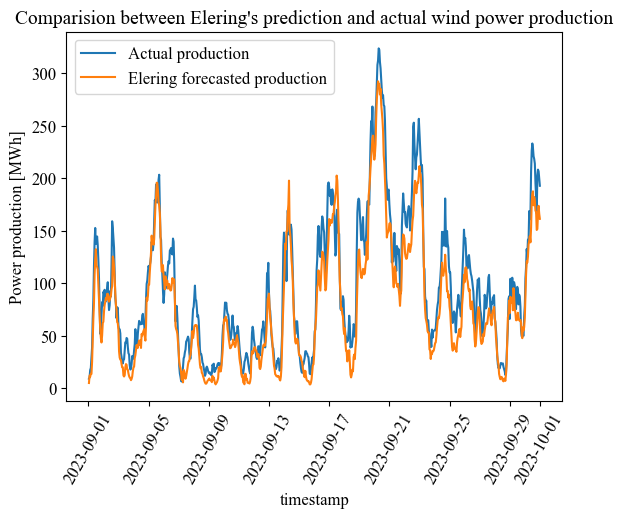

In [5]:
# Plot the actual & forecasted production data
fig1 = plt.figure()
plt.plot(data.index, wp_prod, label="Actual production")
plt.plot(data.index, wp_forecast_brp, label="Elering forecasted production")
plt.title("Comparision between Elering's prediction and actual wind power production")
plt.xlabel("timestamp")
plt.xticks(rotation=60)
plt.ylabel("Power production [MWh]")
plt.legend(loc="best")
plt.show()

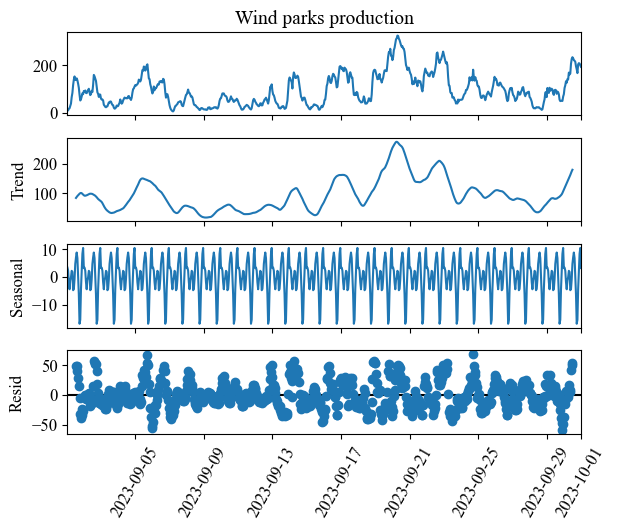

In [6]:
# Decompose seasonal componenet
decompose_result = seasonal_decompose(wp_prod)
fig2 = decompose_result.plot()
plt.xticks(rotation=60);
# The wind production shows seasonal peridocitity on a daily basis

<Figure size 640x480 with 0 Axes>

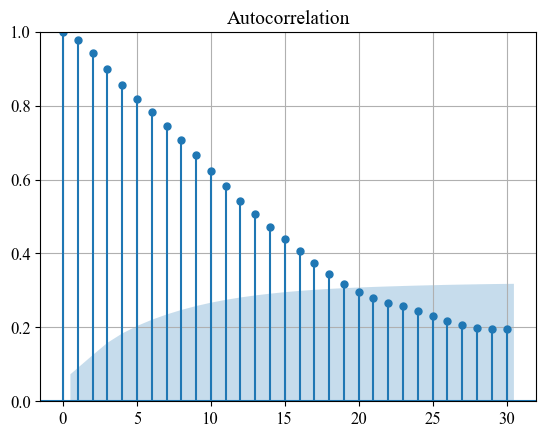

In [7]:
# Plot the autocorrelation plot to check stationarity
_fig = plt.figure()
statsmodels.graphics.tsaplots.plot_acf(wp_prod.values, lags=30)
plt.grid(True)
plt.ylim([0.0, 1.0]);
# Autocorrelation plot does not show exponential decrease, rather decreasing slowly.

(-0.25, 1.0)

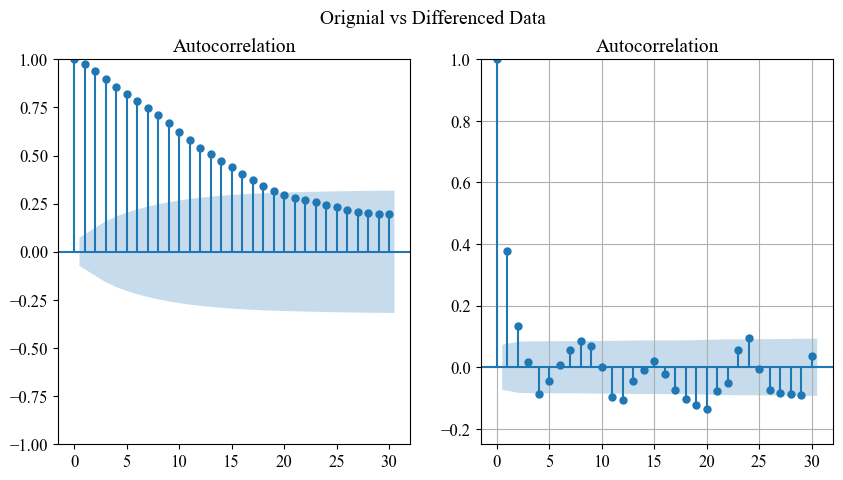

In [8]:
# Apply first order differencing to obtain stationarity of the data
wp_prod_diff = wp_prod.copy()
wp_prod_diff = wp_prod_diff.diff()
wp_prod_diff = wp_prod_diff.dropna()

fig3, ax = plt.subplots(1, 2, figsize=(10, 5))
fig3.suptitle("Orignial vs Differenced Data")
statsmodels.graphics.tsaplots.plot_acf(wp_prod, lags=30, ax=ax[0])
statsmodels.graphics.tsaplots.plot_acf(wp_prod_diff, lags=30, ax=ax[1])
plt.grid(True)
plt.ylim([-0.25, 1.0])

# The 1st order differenced data now shows exponential decline in autocorrelation,
# implying the data is stationary.

In [9]:
# Search for the optimal orders of the SARIMAX model
# Part 1) Manual search

# Load the order data if exsists
if os.path.isfile("./Data/ARIMA_order_results.csv"):
    results = pandas.read_csv("./Data/ARIMA_order_results.csv")
else:
    # Range of orders for the non-seasonal part
    p_range = range(1, 6) # p_min = 1, p_max = 5
    d = 1 # from the previous sections, 1st order differenciation is sufficient
    q_range = range(1, 6) # q_min = 1, q_max = 5
    pdq_combi = [(pq[0], d, pq[1]) for pq in itertools.product(p_range, q_range)]

    # Use the same ranges for seasonal part as well
    # Seasonal period is 24 since the data is daily (i.e., 24hour basis).
    period = 24
    pdq_seasonal_combi = [(pq[0], d, pq[1], period) for pq in itertools.product(p_range, q_range)]

    results = {"SARIMA order": list(), "aic": list()}

    for pdq in pdq_combi:
        for pdq_seasonal in pdq_seasonal_combi:
            try:
                model = SARIMAX(wp_prod, order=pdq, seasonal_order=pdq_seasonal)
                model_fit = model.fit(disp=False)
                print(f"SARIMA: {pdq}{pdq_seasonal} >> aic evaluation: ({model_fit.aic:.2f})")
                results["SARIMA order"].append((pdq, pdq_seasonal))
                results["aic"].append(np.round(model_fit.aic, 2))
            except:
                print(f"SARIMA: {pdq}{pdq_seasonal} >> Cannot be converged!")
                continue

    results = pandas.DataFrame(results)
    results.to_csv("./Data/ARIMA_order_results.csv")

/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA: (1, 1, 1)(1, 1, 1, 24) >> aic evaluation: (5421.14)


/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA: (1, 1, 1)(1, 1, 2, 24) >> aic evaluation: (5422.16)


/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA: (1, 1, 1)(1, 1, 3, 24) >> aic evaluation: (5420.35)


/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)(1, 1, 4, 24) >> aic evaluation: (5421.19)


/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


SARIMA: (1, 1, 1)(1, 1, 5, 24) >> Cannot be converged!


/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/Users/parkhyuntae/opt/anaconda3/envs/enereng2023/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [ ]:
# Search for optimal orders.
# Combination with the smallest aic score is the optimal SARIMA model.
idx_opti = results["aic"].idxmin()
combi_opti = results["SARIMA order"].iloc[idx_opti]

In [ ]:
# Fit the optimal model
model_opti = SARIMAX(wp_prod, order=combi_opti[0], seasonal_order=combi_opti[1])
model_opti_fit = model_opti.fit(disp=False)

model_opti_fit.summary()

In [ ]:
# Load the test data
data_test = pandas.read_csv("./Data/Windparks_October01.csv", sep=";", index_col=1)
data_test.index = pandas.to_datetime(data_test.index, format="mixed", dayfirst=True)
wp_prod_test = data_test["Wind parks production"].str.replace(",", ".")
wp_prod_test = wp_prod_test.astype("float")
wp_forecast_brp_test = data_test["Wind parks production forecast - BRPs"].str.replace(",", ".")
wp_forecast_brp_test = wp_forecast_brp_test.astype("float")

In [ ]:
# Predict using the optimal SARIMAX model
wp_forecast_arima = model_opti_fit.predict(wp_prod_test.index[0],
                                               wp_prod_test.index[-1])
# (Note)
# Should check if index of prediction is in datetime format.
# Check how the prediction result is composed

In [ ]:
# Plot the prediction results.
fig4 = plt.figure(figsize=(8, 6))
plt.plot(data_test.index, wp_prod_test, label="Actual production")
plt.plot(data_test.index, wp_forecast_brp_test, label="Elering forecasted production")
plt.plot(data_test.index, wp_forecast_arima[:, 1], label="ARIMA predicted production")
plt.title("Comparision between Elering's prediction, ARIMA prediction and acutal production")
plt.xlabel("timestamp")
plt.xticks(rotation=60)
plt.ylabel("Power production [MWh]")
plt.legend(loc="best")
plt.show()

In [ ]:
# Evaluate the prediction by RMSE value.
RMSE_ELERING = np.sqrt(mean_squared_error(wp_prod_test, wp_forecast_brp_test))
RMSE_ARIMA = np.sqrt(mean_squared_error(wp_prod_test, wp_forecast_arima[:, 1]))
print(f"RMSE of Elering forecast >> ({RMSE_ELERING})")
print(f"RMSE of ARIMA forecast >> ({RMSE_ARIMA})")